# Exploratory Data Analysis (EDA) for Kaggle Home Price prediction challenge

In [587]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
import numpy as np
import math
import joblib

In [588]:
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Initial data loading and inspection

In [589]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [590]:
pd.set_option('display.max_columns', None)
print(df_train.columns)
df_train.info()
display(df_train.head())
display(df_train.tail())
df_train.describe()
pd.reset_option('display.max_columns')


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [591]:
null_counts = df_train.isnull().sum()
null_percentages = (null_counts / df_train.shape[0]) * 100

pd.set_option('display.max_rows', None)
df_missing_data = pd.DataFrame(
    {
        "MissingCount": null_counts,
        "MissingPercentage": null_percentages
    }
)
display(df_missing_data.head(81))
pd.reset_option('display.max_rows')

,MissingCount,MissingPercentage
Id,0,0.000000
MSSubClass,0,0.000000
MSZoning,0,0.000000
LotFrontage,259,17.739726
LotArea,0,0.000000
Street,0,0.000000
Alley,1369,93.767123
LotShape,0,0.000000
LandContour,0,0.000000
Utilities,0,0.000000


In [592]:
print("Square Footage Features")
print([col for col in df_train.columns if 'SF' in col])

Square Footage Features
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF']


In [593]:
df_train[(df_train["BsmtFinSF1"] > 0) & (df_train["BsmtFinSF2"] > 0)][[col for col in df_train.columns if "Bsmt" in col]].head(5)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
7,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,1,0
24,TA,TA,Mn,Rec,188,ALQ,668,204,1060,1,0
26,TA,TA,Mn,BLQ,234,Rec,486,180,900,0,1
42,Gd,TA,Av,ALQ,747,LwQ,93,0,840,1,0
43,Gd,TA,Av,LwQ,280,BLQ,491,167,938,1,0


<Axes: >

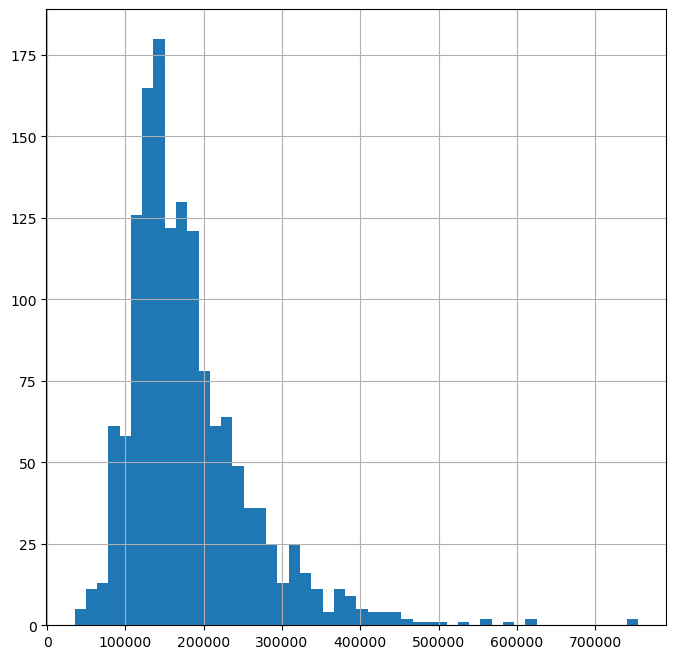

In [594]:
df_train["SalePrice"].hist(bins=50, figsize=(8,8))

<Axes: xlabel='SalePrice', ylabel='Count'>

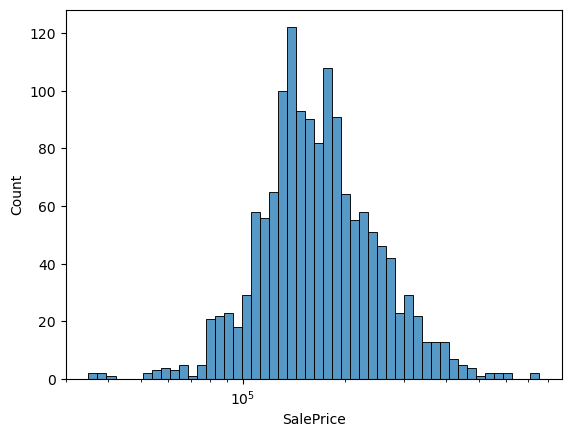

In [595]:
sns.histplot(data=df_train["SalePrice"], log_scale=True, bins=50)

In [596]:
print("Training set size: ", df_train.shape)
print("Test set size: ", df_test.shape)

Training set size:  (1460, 81)
Test set size:  (1459, 80)


In [597]:
display(df_train["SalePrice"].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Observations of dataset #

### I. Feature limitations ###
- **Missingness:** There are several features that have a very high amount of missing data.  Will have to handle some of these features by providing a default value. Those features and missing percentages include:</br>
    • Alley - 93.76% </br>
    • MasVnrType - 59.72%</br>
    • FireplaceQu - 47.26%</br>
    • PoolQC - 99.52%</br>
    • Fence - 80.75%</br>
    • MiscFeature - 96.3%</br>
- At first glance of the dataset, there is no feature designated to total square footage (SF) of the house. Total SF is usually very correlated to the sale price of the home. Listings often break down asking price to price per SF. It will likely be worthwhile to engineer this feature based on other 'area' or SF features.

### II. SalePrice (target) distribution characteristics ###
This seems to represent somewhat real world data where the amount of expensive homes appear less frequently in the market due to affordability of the average person.
- **Skewedness:** The SalePrice data is right skewed with a tail that tapers off towards higher home prices. It would appear that the bulk of home prices lie between $100K -$250K price range. 
- Since the data distribution is skewed, it is recommended to apply a **logarithmic transform** to the SalePrice feature (ex. **np.log1p()**).


# Feature engineering and feature correlation

In [598]:
def total_sqft(row: pd.Series):
    return np.sum([row["GrLivArea"], row["1stFlrSF"], row["2ndFlrSF"], row["TotalBsmtSF"]])

df_train["TotalSF"] = df_train.apply(func=total_sqft, axis=1)

In [599]:
num = df_train.select_dtypes(include=[np.number])
spearman_target_corr = num.corrwith(df_train["SalePrice"], method="spearman").sort_values(ascending=False).to_frame()
pearson_target_corr = num.corrwith(df_train["SalePrice"], method="pearson").sort_values(ascending=False).to_frame()
df_correlations = pd.merge(spearman_target_corr, pearson_target_corr, left_index=True, right_index=True)
df_correlations.rename(columns={"0_x": "SpearmanCorr", "0_y": "PearsonCorr"}).head(25)

,SpearmanCorr,PearsonCorr
SalePrice,1.000000,1.000000
TotalSF,0.810795,0.777123
OverallQual,0.809829,0.790982
GrLivArea,0.731310,0.708624
GarageCars,0.690711,0.640409
YearBuilt,0.652682,0.522897
GarageArea,0.649379,0.623431
FullBath,0.635957,0.560664
TotalBsmtSF,0.602725,0.613581
GarageYrBlt,0.593788,0.486362


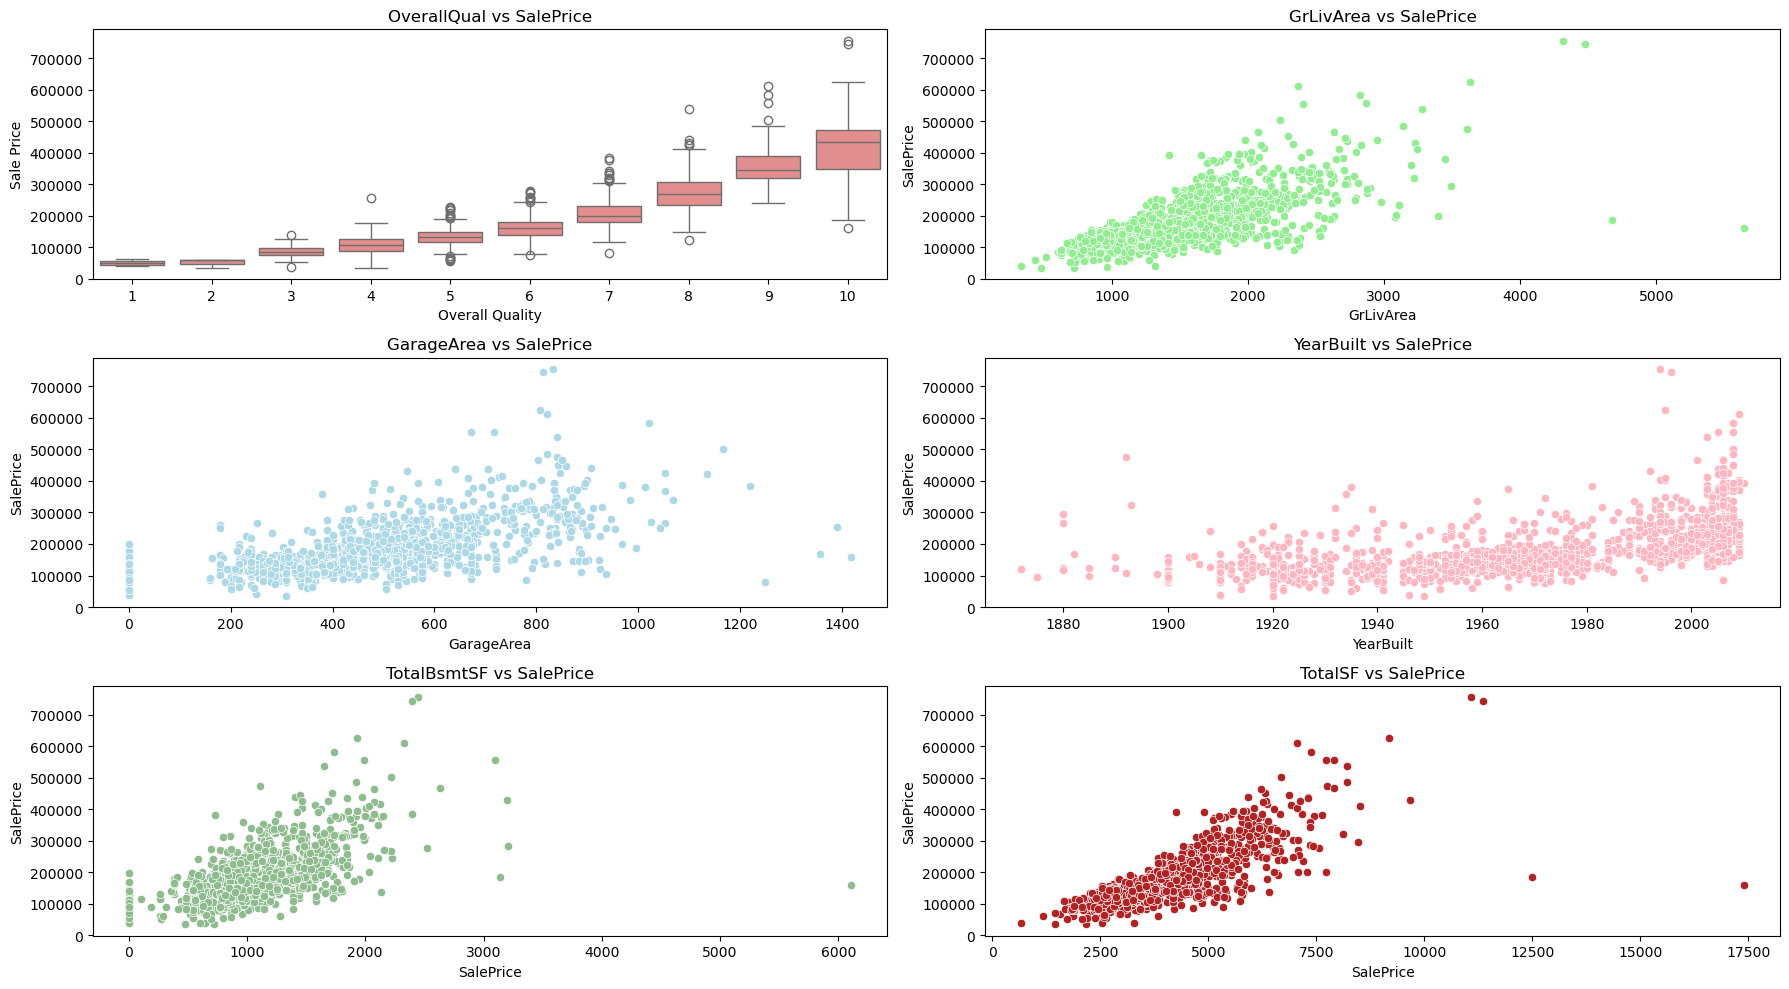

In [600]:
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

sns.boxplot(x=df_train["OverallQual"], y=df_train["SalePrice"], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_title('OverallQual vs SalePrice')
axes[0, 0].set_xlabel('Overall Quality')
axes[0, 0].set_ylabel('Sale Price')

sns.scatterplot(x=df_train["GrLivArea"], y=df_train["SalePrice"], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('GrLivArea vs SalePrice')
axes[0, 1].set_xlabel('GrLivArea')
axes[0, 1].set_ylabel('SalePrice')

sns.scatterplot(x=df_train["GarageArea"], y=df_train["SalePrice"], ax=axes[1, 0], color='lightblue')
axes[1, 0].set_title('GarageArea vs SalePrice')
axes[1, 0].set_xlabel('GarageArea')
axes[1, 0].set_ylabel('SalePrice')

sns.scatterplot(x=df_train["YearBuilt"], y=df_train["SalePrice"], ax=axes[1, 1], color='lightpink')
axes[1, 1].set_title('YearBuilt vs SalePrice')
axes[1, 1].set_xlabel('YearBuilt')
axes[1, 1].set_ylabel('SalePrice')

sns.scatterplot(x=df_train["TotalBsmtSF"], y=df_train["SalePrice"], ax=axes[2, 0], color="darkseagreen")
axes[2, 0].set_title('TotalBsmtSF vs SalePrice')
axes[2, 0].set_xlabel('TotalBsmtSF')
axes[2, 0].set_xlabel('SalePrice')

sns.scatterplot(x=df_train["TotalSF"], y=df_train["SalePrice"], ax=axes[2, 1], color="firebrick")
axes[2, 1].set_title('TotalSF vs SalePrice')
axes[2, 1].set_xlabel('TotalSF')
axes[2, 1].set_xlabel('SalePrice')

plt.tight_layout()
plt.show()

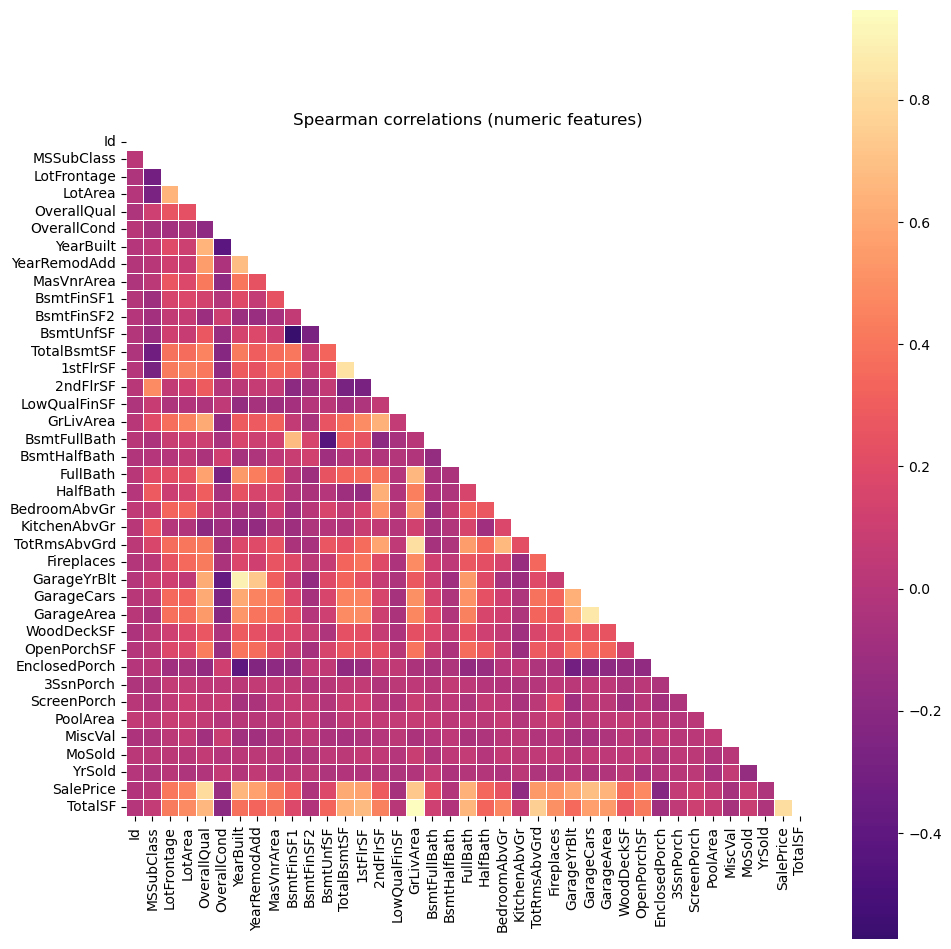

In [601]:
num = df_train.select_dtypes(include=[np.number])
corr_num = num.corr(method="spearman")

mask = np.triu(np.ones_like(corr_num, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr_num, mask=mask, cmap="magma", center=0, square=True, linewidths=.5)
plt.title("Spearman correlations (numeric features)")
plt.tight_layout()
plt.show()

target_corr = corr_num["SalePrice"].sort_values(ascending=False)

# Neighborhood correlation to SalePrice

In [602]:
neighborhood_group = df_train[["SalePrice","Neighborhood"]].groupby("Neighborhood").agg(["count","mean","median"])
neighborhood_group.sort_values(by=('SalePrice', 'median'), ascending=False, inplace=True)
display(neighborhood_group)

SalePrice                         
                 count           mean    median
Neighborhood                                   
NridgHt             77  316270.623377  315000.0
NoRidge             41  335295.317073  301500.0
StoneBr             25  310499.000000  278000.0
Timber              38  242247.447368  228475.0
Somerst             86  225379.837209  225500.0
Veenker             11  238772.727273  218000.0
Crawfor             51  210624.725490  200624.0
ClearCr             28  212565.428571  200250.0
CollgCr            150  197965.773333  197200.0
Blmngtn             17  194870.882353  191000.0
NWAmes              73  189050.068493  182900.0
Gilbert             79  192854.506329  181000.0
SawyerW             59  186555.796610  179900.0
Mitchel             49  156270.122449  153500.0
NPkVill              9  142694.444444  146000.0
NAmes              225  145847.080000  140000.0
SWISU               25  142591.360000  139500.0
Blueste              2  137500.000000  137500.0
Sawyer              74  136793.135135  135000.0
BrkSide             58  124834.051724  124300.0
Edwards            100  128219.700000  121750.0
OldTown            113  128225.300885  119000.0
BrDale              16  104493.750000  106000.0
IDOTRR              37  100123.783784  103000.0
MeadowV             17   98576.470588   88000.0

/var/folders/p8/624x_2fx6db4khk4q9h5l5n00000gn/T/ipykernel_16805/426483561.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighborhoods.sort_values(by="SalePrice", ascending=True, inplace=True)


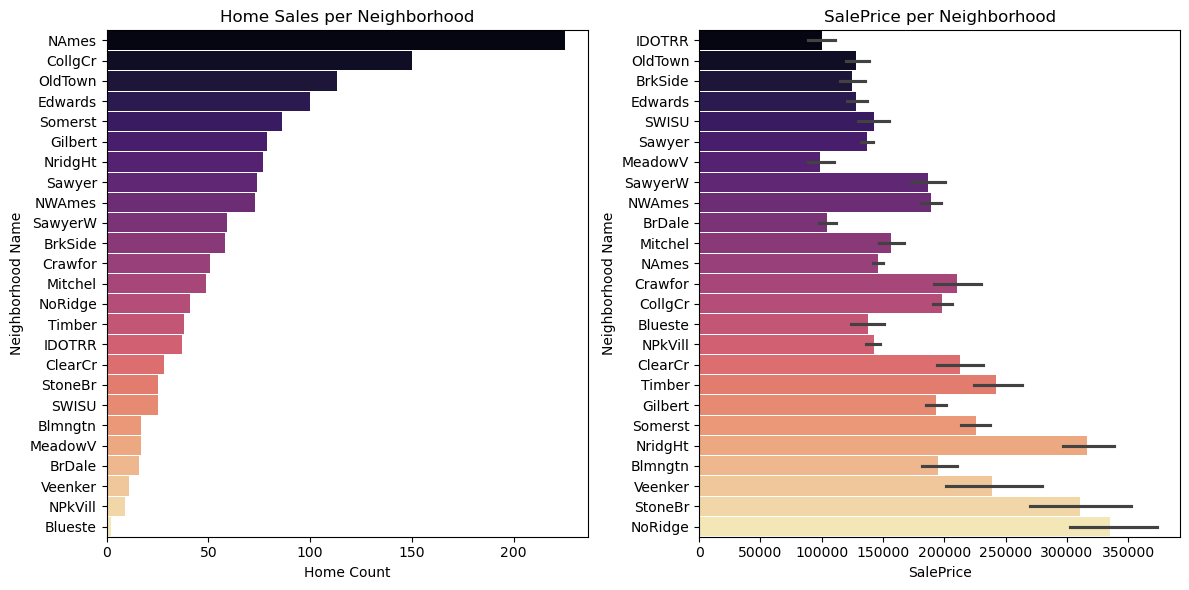

In [603]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

series_neighborhood = df_train["Neighborhood"].sort_values(ascending=True).value_counts()
sns.barplot(x=series_neighborhood.values, y=series_neighborhood.index, hue=series_neighborhood.index,palette="magma", orient="h", ax=axes[0], width=0.95)
axes[0].set_title('Home Sales per Neighborhood')
axes[0].set_xlabel('Home Count')
axes[0].set_ylabel('Neighborhood Name')

df_neighborhoods = df_train[["Neighborhood", "SalePrice"]]
df_neighborhoods.sort_values(by="SalePrice", ascending=True, inplace=True)
sns.barplot(x="SalePrice", y="Neighborhood", data=df_neighborhoods, hue="Neighborhood", orient='h', palette='magma', ax=axes[1], width=0.95)
axes[1].set_title('SalePrice per Neighborhood')
axes[1].set_xlabel('SalePrice')
axes[1].set_ylabel('Neighborhood Name')

plt.tight_layout()
plt.show()

# Ordinal feature mapping

In [604]:
VOCAB_5 = {"Po","Fa","TA","Gd","Ex"}
VOCAB_EXPOSURE = {"No","Mn","Av","Gd"}
VOCAB_FIN = {"Unf","LwQ","Rec","BLQ","ALQ","GLQ"}

ORDINAL_MAPS = {
    "ExterQual": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "ExterCond": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "BsmtQual": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "BsmtCond": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "HeatingQC": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "KitchenQual": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "FireplaceQu": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "GarageQual": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "GarageCond": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "PoolQC": {"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5},
    "BsmtExposure": {"No":0,"Mn":1,"Av":2,"Gd":3},
    "BsmtFinType1": {"Unf":0,"LwQ":1,"Rec":2,"BLQ":3,"ALQ":4,"GLQ":5},
    "BsmtFinType2": {"Unf":0,"LwQ":1,"Rec":2,"BLQ":3,"ALQ":4,"GLQ":5},
    "Functional": {"Sal":0,"Sev":1,"Maj2":2,"Maj1":3,"Mod":4,"Min2":5,"Min1":6,"Typ":7},
    "PavedDrive": {"N":0,"P":1,"Y":2},
    "LandSlope": {"Sev":0,"Mod":1,"Gtl":2},
    "Street": {"Grvl":0,"Pave":1},
}

df_ordinals = df_train.copy()
df_ordinals["SalePrice_log1p"] = np.log1p(df_ordinals["SalePrice"])

for col, m in ORDINAL_MAPS.items():
    if col in df_ordinals.columns:
        df_ordinals[col+"_ord"] = df_ordinals[col].astype("object").fillna("__NA__").map({**m, "__NA__":0})

rows=[]
for col in ORDINAL_MAPS:
    if col+"_ord" in df_ordinals:
        s = df_ordinals[[col+"_ord","SalePrice_log1p"]].dropna()
        rho = s.corr(method="spearman").iloc[0,1] if len(s)>2 else np.nan
        rows.append((col, rho, df_ordinals[col].isna().sum()))
ordinal_strength = (pd.DataFrame(rows, columns=["feature","spearman_rho","n_missing"]))

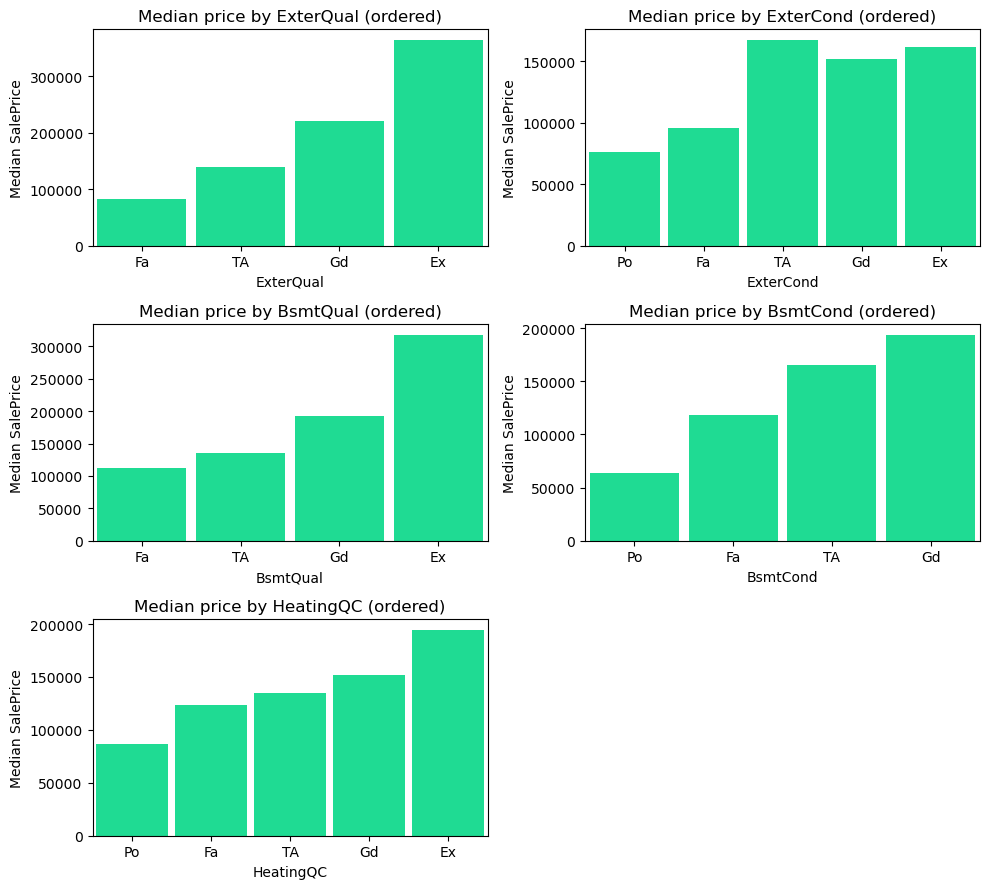

In [605]:
feats = (ordinal_strength["feature"].head(5).tolist()
         if "ordinal_strength" in globals()
         else ordinal_strength["feature"].head(5).tolist())

n = len(feats)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows), squeeze=False)
axes = axes.ravel()  # 1D indexing

for idx, c in enumerate(feats):
    order = sorted(ORDINAL_MAPS[c].items(), key=lambda kv: kv[1])
    cats = [k for k, _ in order]

    tmp = df_train[[c, "SalePrice"]].copy()
    tmp[c] = tmp[c].astype("object").fillna("__NA__")
    med = tmp.groupby(c)["SalePrice"].median().reindex(cats)

    med = med.dropna()

    ax = axes[idx]
    sns.barplot(x=med.index, y=med.values, ax=ax, color="mediumspringgreen", width=0.9)
    ax.set_title(f"Median price by {c} (ordered)")
    ax.set_xlabel(c)
    ax.set_ylabel("Median SalePrice")

# hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [606]:
def correlation_ratio(categories, values):
    s = pd.DataFrame({"c":categories, "y":values}).dropna()
    if s.empty: return np.nan
    cat = s["c"].astype("category")
    y = s["y"].astype(float)
    means = y.groupby(cat, observed=True).mean()
    counts = y.groupby(cat, observed=True).size()
    mean_total = y.mean()
    ss_between = ((means - mean_total)**2 * counts).sum()
    ss_total = ((y - mean_total)**2).sum()
    return np.sqrt(ss_between / ss_total) if ss_total > 0 else np.nan

num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_train.columns if c not in num_cols]

# Association of every feature with the target
assoc = []
for c in df_train.columns:
    if c == "SalePrice": continue
    if c in num_cols:
        val = abs(df_train[c].corr(df_train["SalePrice"], method="spearman"))
        assoc.append((c, val, "num↔num (|Spearman|)"))
    else:
        val = correlation_ratio(df_train[c], df_train["SalePrice"])
        assoc.append((c, val, "cat→num (η)"))

feat_assoc = (pd.DataFrame(assoc, columns=["feature","strength","type"])
                .sort_values("strength", ascending=False))
feat_assoc.head(25)

,feature,strength,type
80,TotalSF,0.810795,num↔num (|Spearman|)
17,OverallQual,0.809829,num↔num (|Spearman|)
12,Neighborhood,0.738630,cat→num (η)
46,GrLivArea,0.731310,num↔num (|Spearman|)
27,ExterQual,0.690933,cat→num (η)
61,GarageCars,0.690711,num↔num (|Spearman|)
53,KitchenQual,0.675721,cat→num (η)
30,BsmtQual,0.673614,cat→num (η)
72,PoolQC,0.669814,cat→num (η)
19,YearBuilt,0.652682,num↔num (|Spearman|)


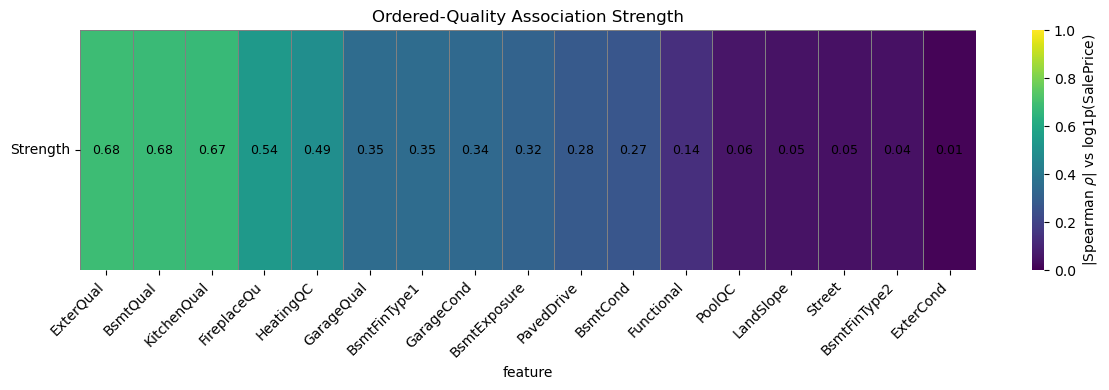

In [607]:
assoc_df = ordinal_strength.copy()

# Identify the correlation column produced earlier
possible_corr_cols = ["spearman_rho", "spearman", "spearman_vs_log_saleprice", "rho"]
corr_col = next((c for c in possible_corr_cols if c in assoc_df.columns), None)
if corr_col is None:
    raise KeyError(f"Expected a Spearman column (one of {possible_corr_cols}) "
                   f"but got columns: {assoc_df.columns.tolist()}")

# Identify the feature-name column (default to 'feature' if present)
feat_col = "feature" if "feature" in assoc_df.columns else assoc_df.columns[0]

# Series of absolute strengths (|Spearman rho|) by feature
S = (assoc_df
     .dropna(subset=[corr_col])          # drop rows with missing correlation
     .set_index(feat_col)[corr_col]       # index by feature name
     .abs()                               # magnitude only for a clean "strength" ranking
     .sort_values(ascending=False))       # strongest features first (left→right in plot)


# Convert to a single-row frame for a compact "strip" heatmap
H = pd.DataFrame([S.values], index=["Strength"], columns=S.index)

fig_w = max(6, 0.6 * len(S) + 2)
plt.figure(figsize=(fig_w, 4))
ax = sns.heatmap(
    H,
    vmin=0, vmax=1,
    cmap="viridis",
    linewidths=.4,
    linecolor="grey",
    cbar_kws={"label": r"|Spearman $\rho$| vs log1p(SalePrice)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Ordered-Quality Association Strength")
plt.tight_layout()

for i, v in enumerate(S.values):
    ax.text(i + 0.5, 0.5, f"{v:.2f}", ha="center", va="center", fontsize=9, color="black")
plt.show()

# Correlation findings
**Objective:** Before fitting models, I assessed which predictors appear most associated with sale price and whether that association is linear or monotonic. The goal is not to “pick winners” purely by correlation, but to understand signal direction, redundancy between features, and where simple linear relationships are likely to break down.

## Method
I computed two complementary correlations against the target:

**Pearson correlation** between each numeric feature and log₁₊(SalePrice). The log transform reduces skew and makes linear association more meaningful for price.

**Spearman rank correlation** for features with a natural order (e.g., OverallQual, KitchenQual, ExterQual, BsmtQual). Mapping these to integers (e.g., Po < Fa < TA < Gd < Ex) preserves their ordinality without assuming equal spacing.

Nominal categoricals with no inherent order (e.g., Neighborhood, Exterior1st) were not evaluated by Pearson/Spearman directly; these are better handled during modeling with encoders and then evaluated via cross-validated performance and group-level residual checks.

### Correlation findings
Across multiple runs, the largest positive associations with log₁₊(SalePrice) consistently included a combination of size/capacity, overall quality, and recency:

**Size/capacity:** The engineered TotalSF (basement + 1st + 2nd floor) exhibited one of the strongest correlations with price, usually exceeding any single component (e.g., 1stFlrSF, GrLivArea). Garage capacity (GarageCars) and total baths also showed moderate positive associations.

**Quality:** The engineered feature TotalSF (total square footage) was at the top of the Spearrman correlatioon and OverallQual ranked near the top in Spearman, with room-specific quality indicators (KitchenQual, ExterQual, BsmtQual) also monotonic with price.

### Redundancy and multicollinearity
Several predictors convey overlapping information. For example, TotalSF, GrLivArea, and 1stFlrSF are strongly correlated with each other; likewise GarageCars and GarageArea. This matters because:

For linear models, multicollinearity can inflate coefficient variance and make interpretations unstable. Choosing a single representative (e.g., TotalSF over separate floor areas) can help.

For tree/boosting models, redundancy is less harmful for accuracy, but feature importance may appear “split” across substitutes. I keep the more interpretable/comprehensive version (e.g., TotalSF) and treat close substitutes as optional.

### Where correlation can mislead
A weak Pearson correlation is not proof of irrelevance. Three common pitfalls:

• **Nonlinearity:** Diminishing returns to size and threshold effects (e.g., going from 2 → 3 bathrooms) can reduce linear correlation even when a feature is useful to a nonlinear model.

• **Outliers:** A small number of extreme homes can distort Pearson. This is one reason I paired Pearson with Spearman, used the log target, and later validated patterns using residual plots.

• **Categoricals:** Spreading a category across many one-hot columns dilutes simple correlations. These features are better judged inside a modeling/encoding context (e.g., target encoding for Neighborhood) and by examining group-level calibration rather than raw correlation.

### Implications for the model stage
The correlation work shaped three concrete choices for modeling:

**Feature inclusion:** Keep high-signal, interpretable aggregates (TotalSF), overall quality, and recency variables as first-class inputs.

**Encoding strategy:** For Neighborhood, I will avoid a large, sparse one-hot and instead use fold-wise target encoding; diagnostics showed this reduced average bias by location without hurting CV error. Ordinal quality fields remain mapped to ordered integers for models to exploit monotonic structure.

**Expectations and diagnostics:** Because correlations are imperfect, I will rely on cross-validated metrics and residual diagnostics (decile calibration, residuals vs. prediction, group residuals) to confirm whether the model is capturing nonlinearity and location effects that simple correlations can’t reveal.

### Reproducibility notes
Correlations were computed on the cleaned training set with the engineered TotalSF in place. Pearson used numeric columns only against log₁₊(SalePrice); Spearman used ordinal-mapped quality fields. For readability, I plotted only the top-k features (rather than a full heatmap), and I kept missing-as-absence handling consistent with what the modeling pipeline will do.

Correlation analysis highlighted the expected drivers (size, quality, recency), warned about redundancies, and motivated better encodings for location (Neighborhood) and ordinal qualities. It does not replace model validation, but it helped me decide which features to emphasize and what to watch for in the next step—model exploration and cross-validated comparison of candidate algorithms.

# Model Exploration

In [608]:
df = df_train.copy()
y = df["SalePrice"].values
X = df.drop(columns=["SalePrice"])

In [609]:
ordinal_cols = [c for c in ORDINAL_MAPS.keys() if c in X.columns]

ordinal_categories = []

for c in ordinal_cols:
    mapping = ORDINAL_MAPS[c]
    ordered_pairs = sorted(mapping.items(), key = lambda kv: kv[1])
    categories_in_order = [k for k, _ in ordered_pairs] + ["__NA__"]
    ordinal_categories.append(categories_in_order)


In [610]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.to_list()
numeric_cols = [c for c in numeric_cols if c.lower() != "id"]
nominal_cols = [c for c in X.columns if c not in num_cols and c not in ordinal_cols]

nominal_colsv2 = [c for c in X.columns if c not in num_cols and c not in ordinal_cols and "Neighborhood" not in c]

pipeline_ordinal = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="__NA__")),
    ("ord_enc", OrdinalEncoder(categories=ordinal_categories,
                           handle_unknown="use_encoded_value", unknown_value=np.nan)),
    # No scaling: these are already on a small integer scale that encodes rank.
])

pipeline_numeric = Pipeline(steps= [
    ("imp", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler(with_mean=True, with_std=True))
])

pipeline_nominal = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("1h_enc", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

pipeline_target = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("tgt_enc", TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=42))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", pipeline_ordinal, ordinal_cols),
        ("num", pipeline_numeric, numeric_cols),
        ("nom", pipeline_nominal, nominal_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessorv2 = ColumnTransformer(
    transformers=[
        ("ord", pipeline_ordinal, ordinal_cols),
        ("num", pipeline_numeric, numeric_cols),
        ("nom", pipeline_nominal, nominal_colsv2),
        ("tgt", pipeline_target, ["Neighborhood"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [611]:
def make_model(estimator, preprocessor):
    pipeline = Pipeline(
        steps=[
            ("pipe", preprocessor),
            ("model", estimator)
        ]
    )
    return TransformedTargetRegressor(
        regressor=pipeline,
        func=np.log1p,
        inverse_func=np.expm1
    )

In [612]:
models = {
    "Ridge": make_model(estimator=Ridge(alpha=0.5, random_state=0), preprocessor=preprocessor),
    "Lasso": make_model(estimator=Lasso(alpha=0.5, random_state=0), preprocessor=preprocessor),
    "HGBR":  make_model(estimator=HistGradientBoostingRegressor(max_depth=None, 
                                                                learning_rate=0.08, 
                                                                max_iter=600, 
                                                                l2_regularization=0.0,
                                                                min_samples_leaf=25, 
                                                                random_state=0),
                                                                preprocessor=preprocessor),
    "HGBR2":  make_model(estimator=HistGradientBoostingRegressor(max_depth=None, 
                                                                learning_rate=0.08, 
                                                                max_iter=600, 
                                                                l2_regularization=0.0,
                                                                min_samples_leaf=25, 
                                                                random_state=0),
                                                                preprocessor=preprocessorv2),
    "LGBMReg": make_model(estimator=LGBMRegressor(n_estimators=1200, 
                                                  learning_rate=0.05, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  reg_lambda=1.0, 
                                                  random_state=0),
                                                  preprocessor=preprocessorv2),
    "XGBReg": make_model(estimator=XGBRegressor(n_estimators=1200, 
                                                learning_rate=0.05, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                max_depth=6, 
                                                reg_lambda=1.0, 
                                                tree_method="hist", 
                                                random_state=0),
                                                preprocessor=preprocessorv2)
}

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Ridge: RMSE mean=49,067  std=53,365
Lasso: RMSE mean=80,513  std=5,513
HGBR: RMSE mean=30,125  std=6,598
HGBR2: RMSE mean=29,088  std=5,851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3500
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 132
[LightGBM] [Info] Start training from score 12.022759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005330 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

/usr/local/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: 

LGBMReg: RMSE mean=28,454  std=5,557
XGBReg: RMSE mean=28,363  std=5,325


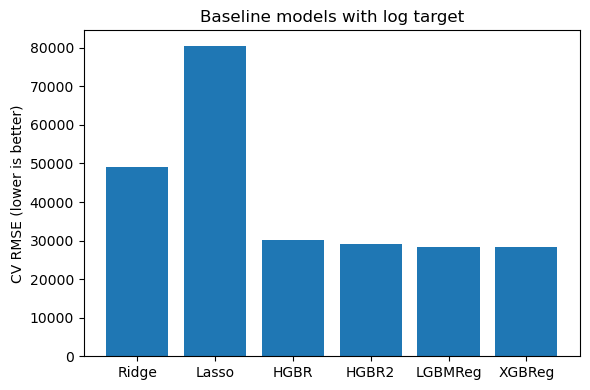

Best baseline by CV: XGBReg


In [613]:
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=cv, n_jobs=-1)
    results[name] = -scores
    print(f"{name}: RMSE mean={-scores.mean():,.0f}  std={scores.std():,.0f}")

plt.figure(figsize=(6,4))
plt.bar(list(results.keys()), [v.mean() for v in results.values()])
plt.ylabel("CV RMSE (lower is better)")
plt.title("Baseline models with log target")
plt.tight_layout()
plt.show()

best_name = min(results, key=lambda k: results[k].mean())
best_model = models[best_name]
best_model.fit(X, y)
print(f"Best baseline by CV: {best_name}")

In [614]:
def out_of_fold_preds(estimator,X:pd.DataFrame, y, n_splits: int=5, random_state:int=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_pred = np.full_like(y, np.nan, dtype=float)
    
    for _, (tr, va) in enumerate(kf.split(X, y)):
        est = clone(estimator)
        est.fit(X.iloc[tr], y[tr])
        oof_pred[va] = est.predict(X.iloc[va])
    return oof_pred

# Residuals vs Predicted

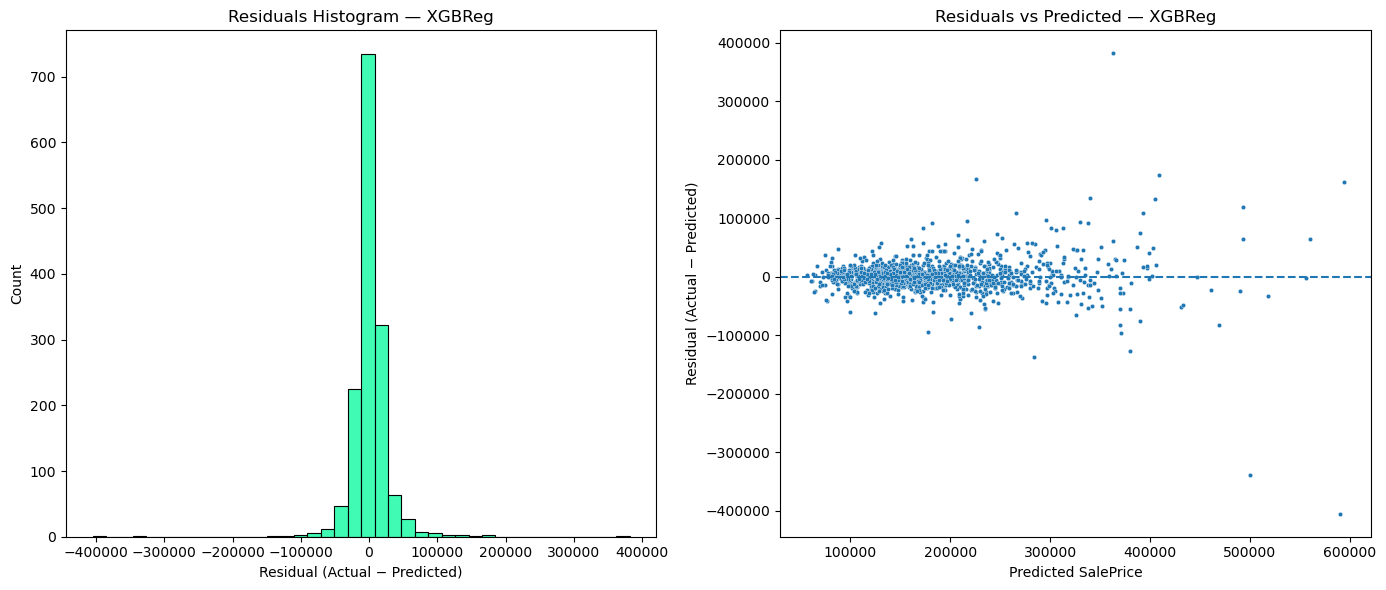

In [615]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

oof = out_of_fold_preds(estimator=models[best_name],X=X, y=y)
residuals = y - oof
rmse = np.sqrt(mean_squared_error(y_true=y, y_pred=oof))

sns.histplot(x=residuals[~np.isnan(residuals)], bins=40, ax=axes[0], color="mediumspringgreen")
axes[0].set_title(f"Residuals Histogram — {best_name}")
axes[0].set_xlabel("Residual (Actual − Predicted)")
axes[0].set_ylabel("Count")

sns.scatterplot(x=oof, y=residuals, s=10, ax=axes[1]) 
axes[1].axhline(0.0, linestyle="--")
axes[1].set_title(f"Residuals vs Predicted — {name}")
axes[1].set_xlabel("Predicted SalePrice")
axes[1].set_ylabel("Residual (Actual − Predicted)")

plt.tight_layout()
plt.show()

    

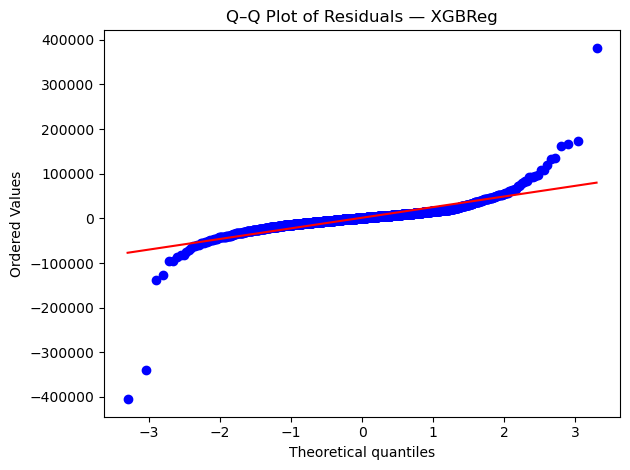

In [616]:
plt.figure()
ss.probplot(residuals[~np.isnan(residuals)], dist="norm", plot=plt)
plt.title(f"Q–Q Plot of Residuals — {best_name}")
plt.tight_layout()
plt.show()

/var/folders/p8/624x_2fx6db4khk4q9h5l5n00000gn/T/ipykernel_16805/336498576.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal_stats = cal.groupby("bin").agg(mean_pred=("pred","mean"),


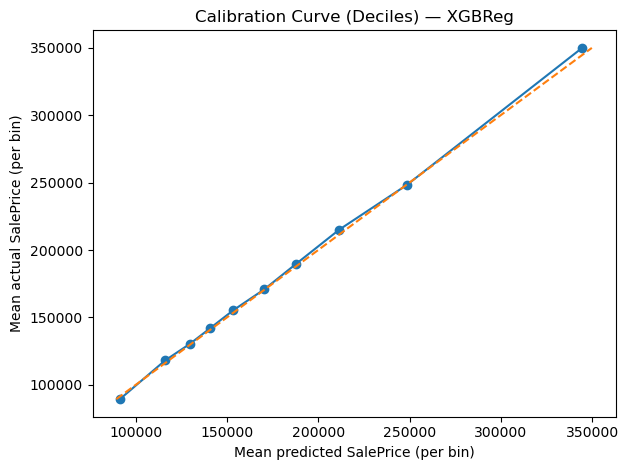

In [617]:
cal = pd.DataFrame({"pred": oof, "actual": y}).dropna()
cal["bin"] = pd.qcut(cal["pred"], q=10, duplicates="drop")  # 10 equally populated bins
cal_stats = cal.groupby("bin").agg(mean_pred=("pred","mean"),
                                   mean_actual=("actual","mean"),
                                   count=("actual","size")).reset_index()

plt.figure()
plt.plot(cal_stats["mean_pred"], cal_stats["mean_actual"], marker="o")
# y=x reference (perfect calibration)
lo = float(np.min([cal_stats["mean_pred"].min(), cal_stats["mean_actual"].min()]))
hi = float(np.max([cal_stats["mean_pred"].max(), cal_stats["mean_actual"].max()]))
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.title(f"Calibration Curve (Deciles) — {best_name}")
plt.xlabel("Mean predicted SalePrice (per bin)")
plt.ylabel("Mean actual SalePrice (per bin)")
plt.tight_layout()
plt.show()

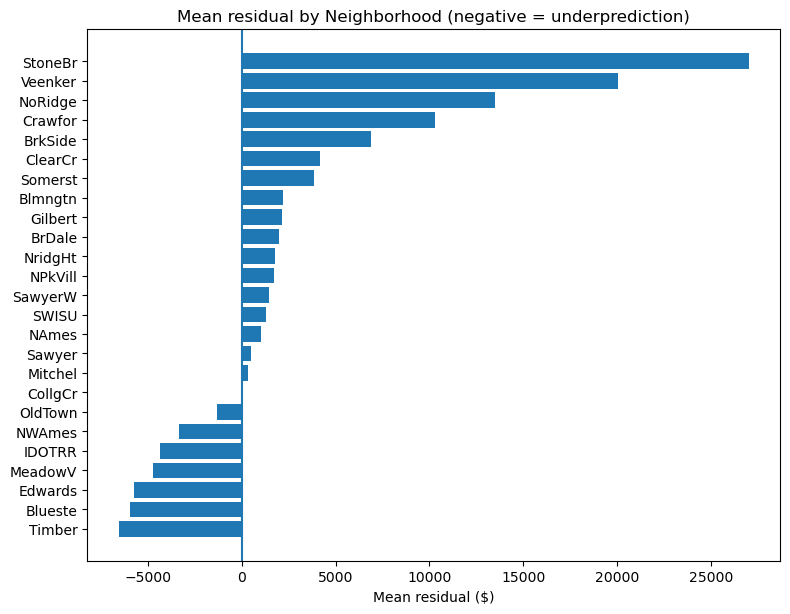

In [618]:
if "Neighborhood" in df.columns:
    g = pd.DataFrame({"Neighborhood": df["Neighborhood"], "residual": residuals}).dropna()
    neigh = g.groupby("Neighborhood")["residual"].mean().sort_values()
    plt.figure(figsize=(8, max(3, 0.25*len(neigh))))
    y_pos = np.arange(len(neigh))
    plt.barh(y_pos, neigh.values)
    plt.yticks(y_pos, neigh.index)
    plt.axvline(0.0, linestyle="-")
    plt.title("Mean residual by Neighborhood (negative = underprediction)")
    plt.xlabel("Mean residual ($)")
    plt.tight_layout()
    plt.show()

# Model Selection Summary

**Objective:** Pick a regression model that (i) generalizes well (low CV RMSE on the dollar scale), (ii) stays well-calibrated across the price range and neighborhoods, and (iii) is simple to explain.

**Candidates & features:** Compared Ridge/Lasso, HistGradientBoosting, LightGBM, and XGBoost using the same preprocessing: engineered TotalSF, ordinal-mapped quality fields, TargetEncoded(Neighborhood) (fold-wise, smoothed), median-imputed/scaled numerics, OHE for remaining nominals. Target modeled as log₁₊(SalePrice) and inverted with expm1.

**Evaluation protocol:** 5-fold KFold (same folds for all models), metric = RMSE on real-price scale, all preprocessing (incl. TE) fit inside the folds to avoid leakage. Decile calibration and residual plots reviewed on OOF predictions.

**Tuning approach:** First pass with strong defaults to identify the best family; then per-fold early stopping for boosters; finally a small RandomizedSearchCV over learning rate, depth/leaves, sampling, and L2.

### Results (OOF CV)
Ridge/Lasso underfit; HGBR/LightGBM competitive; XGBoost achieved the best mean CV RMSE with tight fold std and near-perfect decile calibration.
(Replace with your numbers: e.g., XGB [mean] ± [std], HGBR [mean] ± [std], LGBM [mean] ± [std].)

**Decision:** Select XGBoost with the shared preprocessing. Use early stopping to set effective rounds per fold, consolidate to a final n_estimators, then fit on all training rows.

In [619]:
def hp_tune(est, scorer, X, y):
    try:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)

        param_dist = {
            "regressor__model__learning_rate":  np.logspace(-2.3, -0.7, 20),
            "regressor__model__max_depth":     [15, 31, 63, 127],
            "regressor__model__min_child_weight": [5, 10, 20, 30, 50],
            "regressor__model__subsample":      [0.7, 0.8, 0.9, 1.0],
            "regressor__model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
            "regressor__model__reg_lambda":     np.logspace(-3, 1, 8),
        }

        search = RandomizedSearchCV(
            estimator=est,
            param_distributions=param_dist,
            n_iter=40, scoring=scorer, cv=cv, n_jobs=-1, random_state=42, refit=True, verbose=1
        )

        search.fit(X=X, y=y)
        
        return search.best_estimator_, search.best_score_
    except Exception as e:
        raise e

In [620]:
best_estimator, best_score = hp_tune(est=best_model, scorer=rmse_scorer, X=X, y=y)
print("Best RMSE:", best_score)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RMSE: -26748.91618061912


In [621]:
df_test["TotalSF"] = df_test.apply(func=total_sqft, axis=1)
X_test = df_test.copy()

In [622]:
preds = best_estimator.predict(X_test)

In [623]:
sub = pd.DataFrame({"Id": X_test["Id"], "SalePrice": preds})
sub.to_csv("submission.csv", index=False)
sub.head(5)

,Id,SalePrice
0,1461,122895.765625
1,1462,156118.625000
2,1463,189158.125000
3,1464,193875.078125
4,1465,187120.250000


# Save Model
The model was packaged using KitOps and pushed to a repository on JozuHub. The model artifacts can be found here: https://jozu.ml/repository/blazekotsenburg/kaggle_home_price_xgbr/latest/contents

In [624]:
joblib.dump(best_estimator, "models/kaggle-home-price-xgbregressor.joblib")

['models/kaggle-home-price-xgbregressor.joblib']